## Customer Churn Predictions

Dependencies: <br> 
pandas, numpy, scikit-learn, imbalanced-learn, matplotlib, seaborn, plotly, xgboost, shap, joblib

In [1]:
# Setting random seed 
random_state = 42 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 


In [3]:
# Doing a check on the current directory/parent directories for defining the data path 
import os 
print("cwd:", os.getcwd()) 
print("Files here:", os.listdir()) 
print("Parent files:", os.listdir(".."))

cwd: /workspaces/Customer-Churn-Prediction/Notebooks
Files here: ['customer_churn_pred.ipynb']
Parent files: ['Data', 'README.md', 'Visuals', '.git', 'demo.ipynb', 'Models', 'Notebooks', 'predict.py', '.venv']


In [ ]:
# Updating display options 
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None) 

In [5]:
# Loading data 
data_path = "../Data/telco_churn_data.csv"
telco_data = pd.read_csv(data_path)  
print(telco_data.info()) 
print("\n", telco_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Checking for duplicates (customerID) 
telco_data['customerID'].nunique() == len(telco_data)

True

In [7]:
telco_data.shape 

(7043, 21)

In [8]:
telco_data.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6531,2
top,3186-AJIEK,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


In [9]:
telco_data.isnull().sum() 

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [10]:
telco_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [11]:
# Renaming columns 
cleaned_data = telco_data.rename(columns={
    'customerID': 'customer_id', 
    'gender': 'gender', 
    'SeniorCitizen': 'senior_citizen', 
    'Partner': 'partner', 
    'Dependents': 'dependents', 
    'tenure': 'tenure', 
    'PhoneService': 'phone_service', 
    'MultipleLines': 'multiple_lines', 
    'InternetService': 'internet_service', 
    'OnlineSecurity': 'online_security', 
    'OnlineBackup': 'online_backup', 
    'DeviceProtection': 'device_protection', 
    'TechSupport': 'tech_support', 
    'StreamingTV': 'streaming_tv', 
    'StreamingMovies': 'streaming_movies',
    'Contract': 'contract', 
    'PaperlessBilling': 'paperless_billing', 
    'PaymentMethod': 'payment_method', 
    'MonthlyCharges': 'monthly_charges', 
    'TotalCharges': 'total_charges', 
    'Churn': 'churn'
})




In [12]:
print(cleaned_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   int64  
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   tenure             7043 non-null   int64  
 6   phone_service      7043 non-null   object 
 7   multiple_lines     7043 non-null   object 
 8   internet_service   7043 non-null   object 
 9   online_security    7043 non-null   object 
 10  online_backup      7043 non-null   object 
 11  device_protection  7043 non-null   object 
 12  tech_support       7043 non-null   object 
 13  streaming_tv       7043 non-null   object 
 14  streaming_movies   7043 non-null   object 
 15  contract           7043 non-null   object 
 16  paperless_billing  7043 

In [ ]:
# Adjusting total_charges column to numeric 
cleaned_data['total_charges'] = pd.to_numeric(cleaned_data['total_charges'], errors='coerce') 


In [14]:
# Renaming Data Values 
""" 
column: senior_citizen 

    --> Changing to (Yes, No) to match the other columns 
        - Currently has (1, 0)

column: contract 
    
    --> Changing to (month_to_month, one_year, two_year) 
        - Currenty has (Month-to-month, One year, Two year) 

column: payment_method 

    --> Changing to (electronic_check, mailed_check, bank_transfer, credit_card) 
        - Currently has (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)) 

"""

# Storing mapping for senior_citizen
senior_citizen_map = {1: "Yes", 0: "No"} 
# Applying mapping 
cleaned_data['senior_citizen'] = cleaned_data['senior_citizen'].map(senior_citizen_map) 

# Storing mapping for contract
contract_map = {
    "Month-to-month": "month_to_month", 
    "One year": "one_year", 
    "Two year": "two_year" 
}
# Applying mapping 
cleaned_data['contract'] = cleaned_data['contract'].map(contract_map) 

# Storing mapping for payment_method 
payment_method_map = {
    "Electronic check": "electronic_check", 
    "Mailed check": "mailed_check", 
    "Bank transfer (automatic)": "bank_transfer", 
    "Credit card (automatic)": "credit_card" 
}
# Applying mapping 
cleaned_data['payment_method'] = cleaned_data['payment_method'].map(payment_method_map)  


# Retaining original values 
reverse_senior_citizen_map = {v: k for k, v in senior_citizen_map.items()} 
# Decoding back 
#data['senior_citizen'] = data['senior_citizen'].map(reverse_senior_citizen_map) 

reverse_contract_map = {v: k for k, v in contract_map.items()} 
# Decoding back 
#data['contract'] = data['contract'].map(reverse_contract_map) 

reverse_payment_method_map = {v: k for k, v in payment_method_map.items()} 
# Decoding back 
#data['payment_method'] = data['payment_method'].map(reverse_payment_method_map) 



In [15]:
print(cleaned_data.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   object 
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   tenure             7043 non-null   int64  
 6   phone_service      7043 non-null   object 
 7   multiple_lines     7043 non-null   object 
 8   internet_service   7043 non-null   object 
 9   online_security    7043 non-null   object 
 10  online_backup      7043 non-null   object 
 11  device_protection  7043 non-null   object 
 12  tech_support       7043 non-null   object 
 13  streaming_tv       7043 non-null   object 
 14  streaming_movies   7043 non-null   object 
 15  contract           7043 non-null   object 
 16  paperless_billing  7043 

In [16]:
data = cleaned_data.copy() 

### EDA

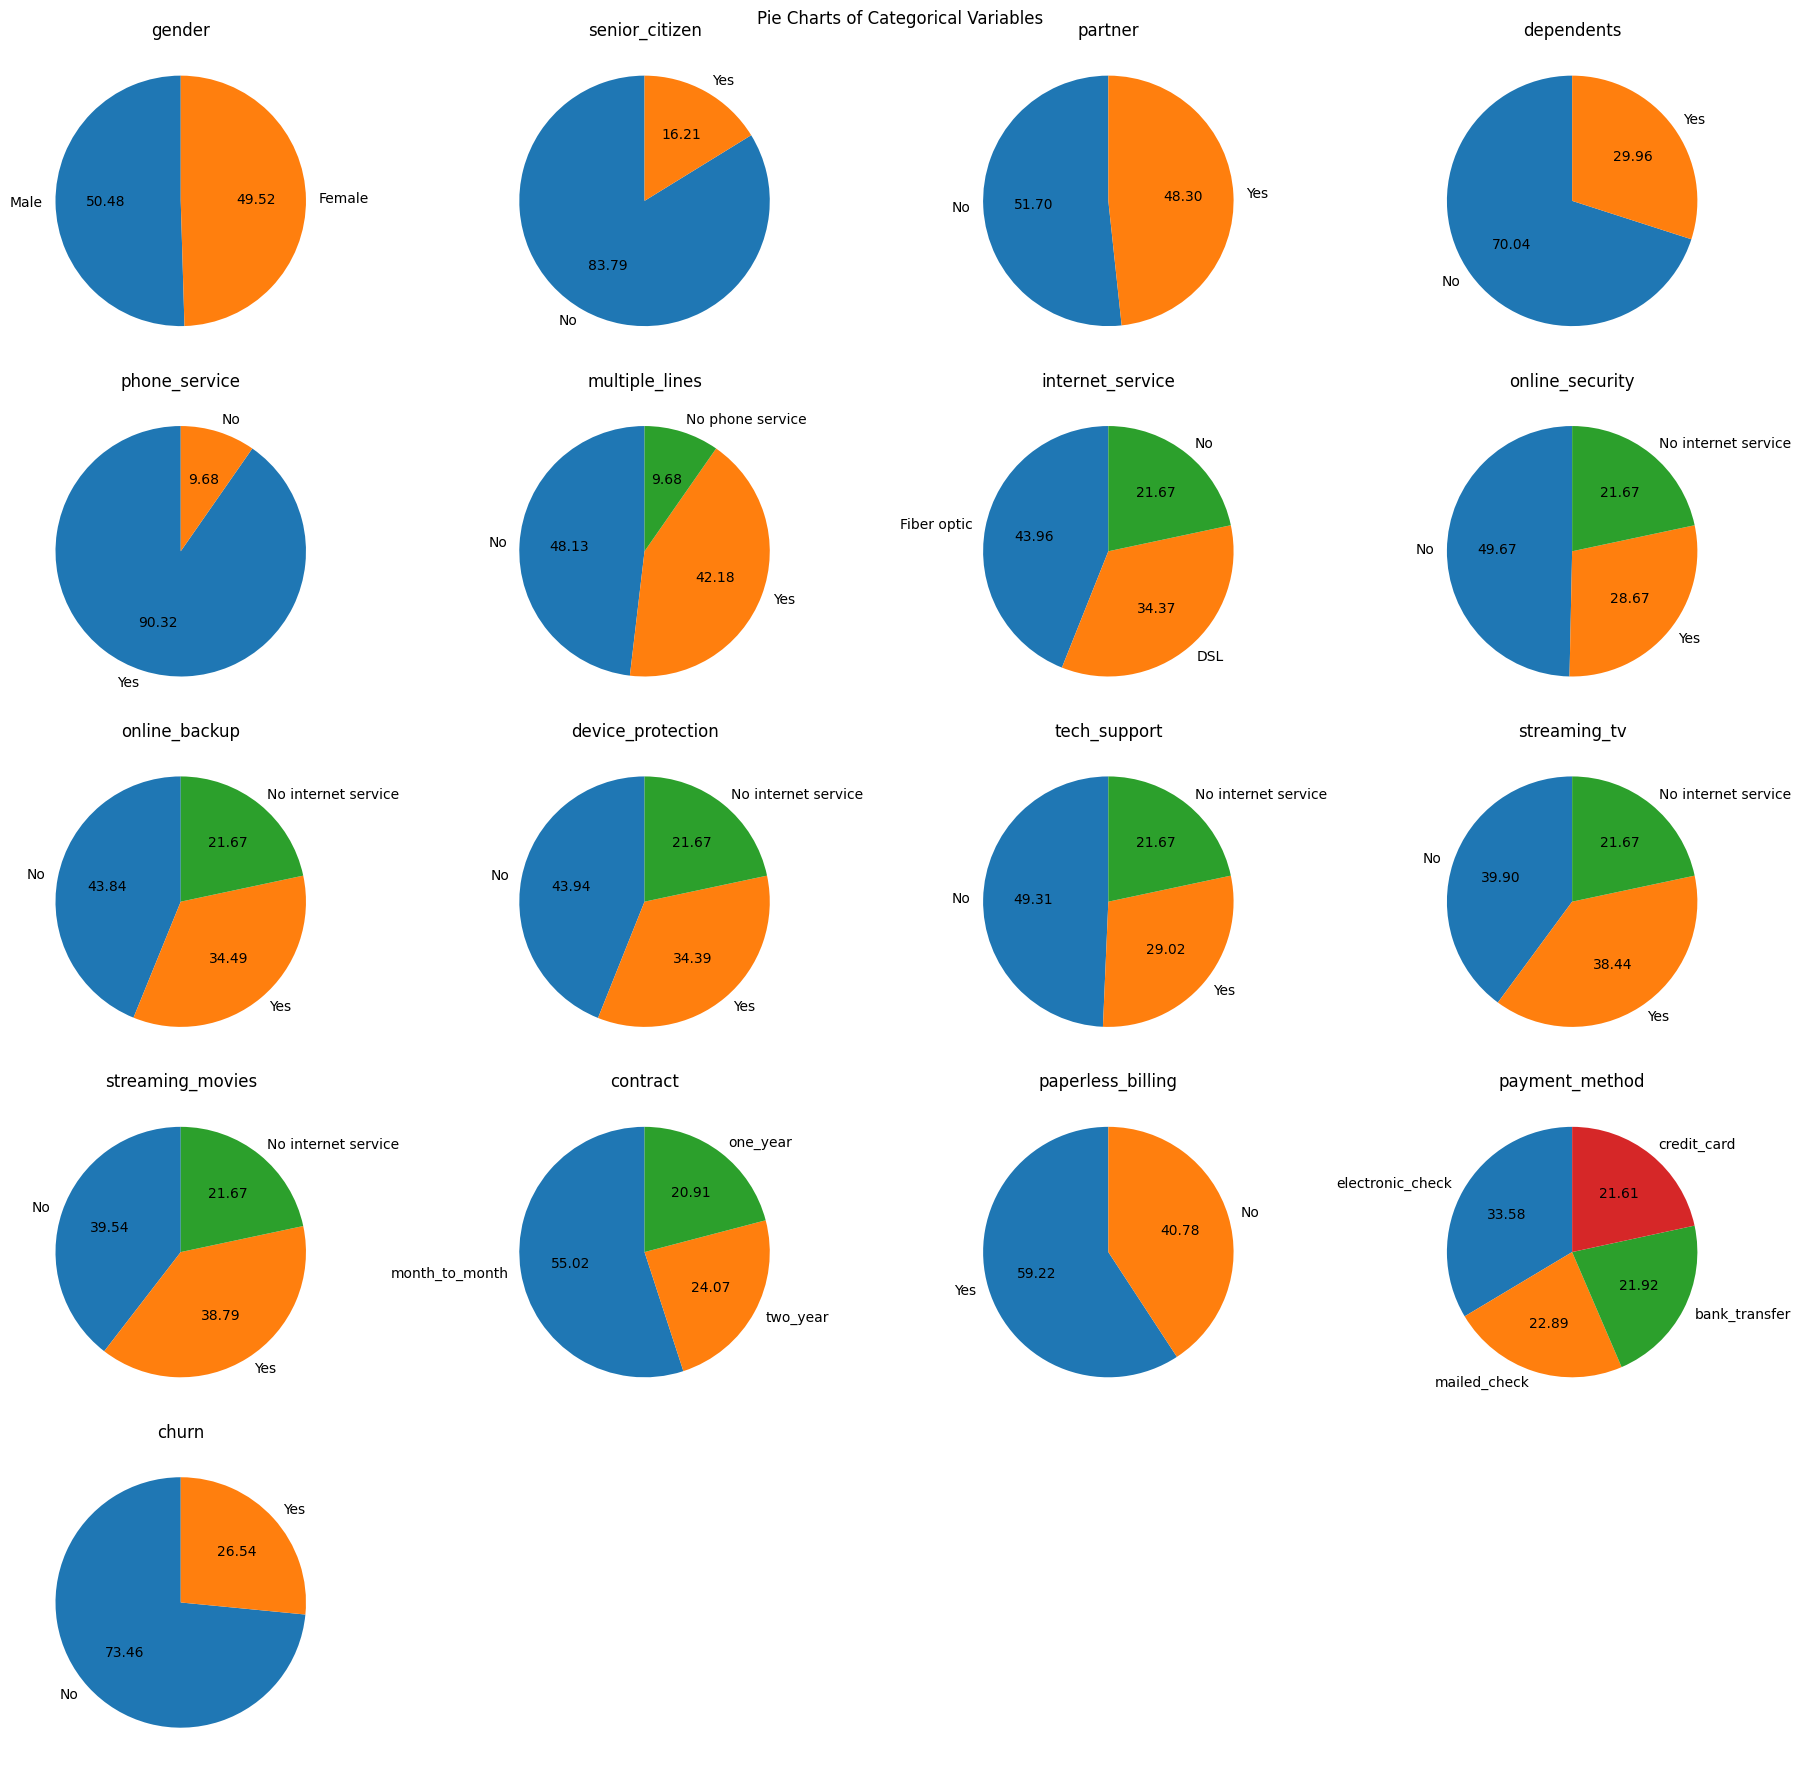

In [17]:
# Function to plot pie charts of the categorical variables in subplots 
def plot_pie_charts(data): 
    # Selecting categorical columns (Except for customer_id) 
    categorical_cols = data.select_dtypes(include=['object']).columns 
    categorical_cols = [col for col in categorical_cols if col.lower() !='customer_id'] 
    total_pie_charts = len(categorical_cols) 

    # Defining subplot layout 
    rows, cols = 5, 4 
    fig, axes = plt.subplots(rows, cols, figsize=(18, 18)) 
    fig.suptitle('Pie Charts of Categorical Variables') 

    # Making it easier to loop 
    axes = axes.flatten() 
    for idx, col in enumerate(categorical_cols): 
        counts = data[col].value_counts() 
        axes[idx].pie(counts, labels=counts.index, autopct="%.2f", startangle=90)
        axes[idx].set_title(col) 

    # Turning off unused subplots 
    for ax in axes[total_pie_charts:]: 
        ax.axis('off') 

    plt.tight_layout() 
    plt.show() 


plot_pie_charts(data) 


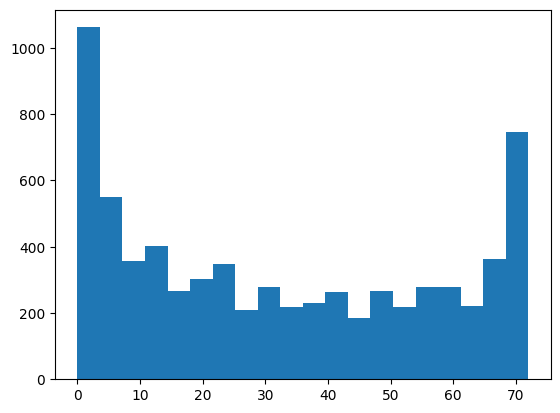

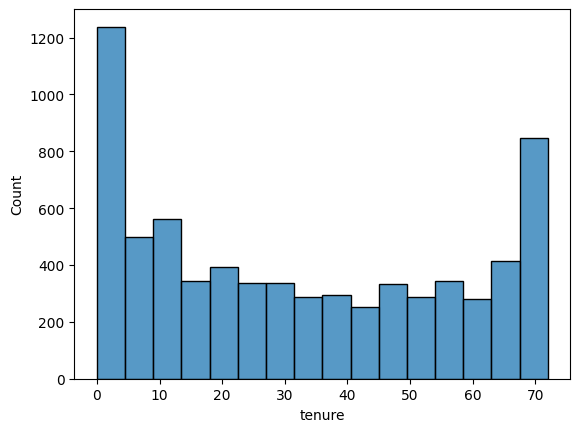

In [18]:
# Histogram plot and Histplot of tenure (# of months the customer has stayed with the company) 
plt.hist(data['tenure'], bins=20) 
plt.show() 

sns.histplot(data['tenure']) 
plt.show() 


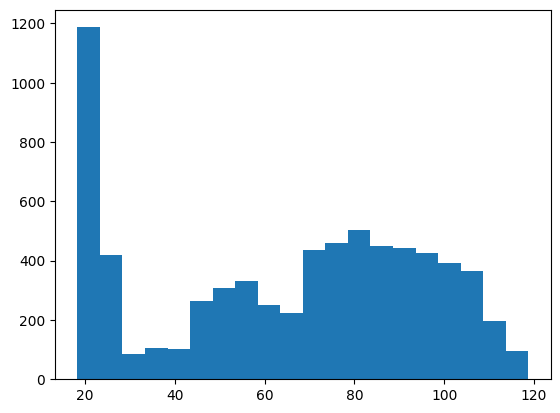

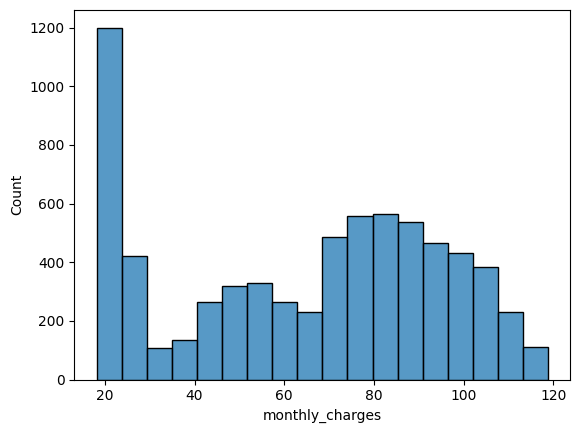

In [19]:
# Histogram plot and Histplot of monthly_charges 
plt.hist(data['monthly_charges'], bins=20) 
plt.show() 

sns.histplot(data['monthly_charges']) 
plt.show() 


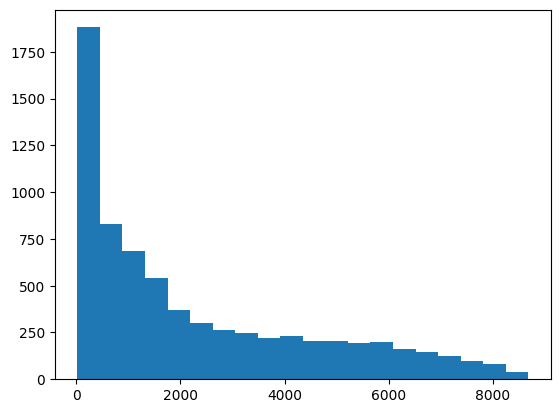

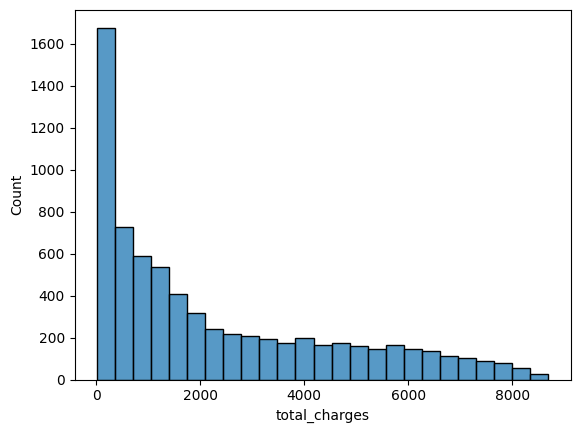

In [20]:
# Histogram plot and Histplot of total_charges 
plt.hist(data['total_charges'], bins=20) 
plt.show() 

sns.histplot(data['total_charges']) 
plt.show() 


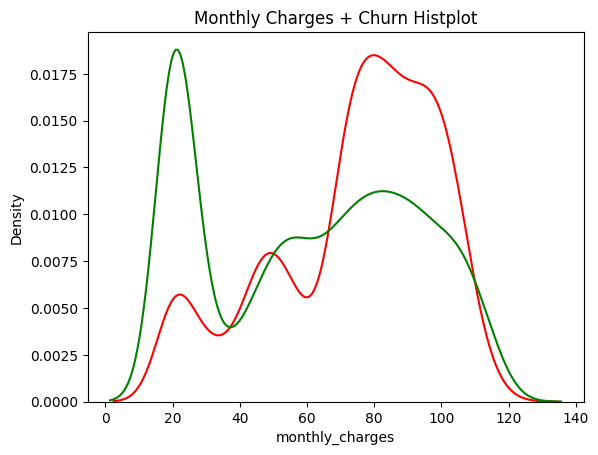

In [ ]:
# Histplot of monthly_charges and churn 
sns.kdeplot(data[data['churn'] == "Yes"]['monthly_charges'], color='red') 
sns.kdeplot(data[data['churn'] == "No"]['monthly_charges'], color='green') 
plt.title('Monthly Charges + Churn Histplot') 
plt.show() 



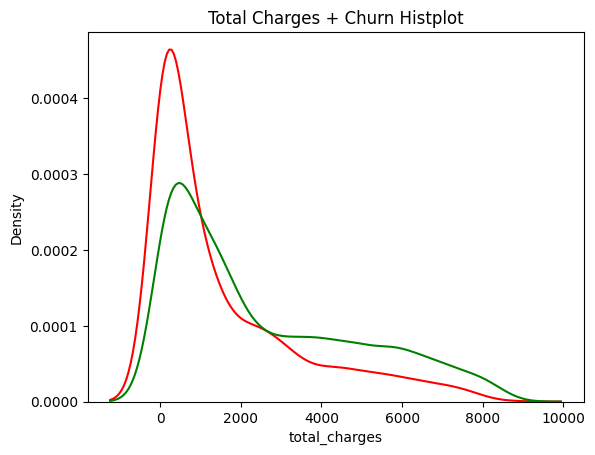

In [23]:
# Histplot of total_charges and churn 
sns.kdeplot(data[data['churn'] == "Yes"]['total_charges'], color='red') 
sns.kdeplot(data[data['churn'] == "No"]['total_charges'], color='green') 
plt.title('Total Charges + Churn Histplot') 
plt.show() 


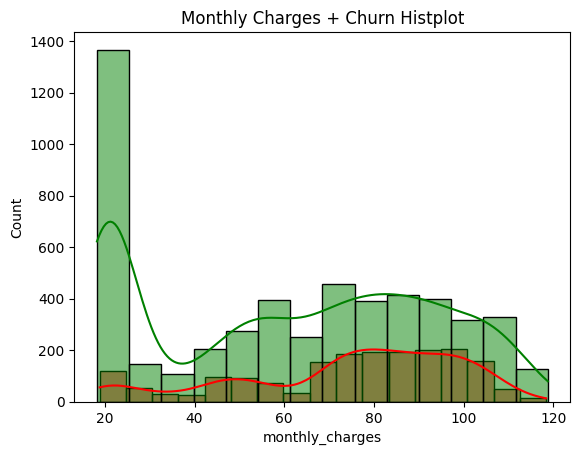

In [24]:
sns.histplot(data[data['churn'] == "Yes"]['monthly_charges'], color='red', kde=True) 
sns.histplot(data[data['churn'] == "No"]['monthly_charges'], color='green', kde=True) 
plt.title('Monthly Charges + Churn Histplot') 
plt.show() 